In [1]:
# Define an environment at OpenAI style

In [2]:
import random as rnd
import numpy as np

In [3]:
class Passenger:
    def __init__(self, pid):
        self.id=pid
        self.isWindower=str(self.id).endswith('w')
        self.position=None
        self.status=0 # 0:'QUEUED_TO_BOARD', 1:'NEXT_TO_BOARD', 2:'PLACED_IN_PLANE'

In [4]:
class PassengerList:
    def __init__(self, groups):
        self.groups=groups
        self.index_group=0
        self.index_passenger_ingroup=0
        self.completed=False
        self.groups[0][0].status=1
    
    def getNextAndUpdate(self):
        current_passenger = self.getNext()
        if current_passenger is None:
            return None
        else:
            self.index_passenger_ingroup = (self.index_passenger_ingroup + 1) % len(self.groups[self.index_group])
            if (self.index_passenger_ingroup == 0):
                self.index_group = (self.index_group + 1) % len(self.groups)
                if (self.index_group == 0):
                    self.completed = True
            if (self.completed==False):
                self.groups[self.index_group][self.index_passenger_ingroup].status=1
            return current_passenger
    
    def getNext(self):
        if (self.completed):
            return None
        else:
            return self.groups[self.index_group][self.index_passenger_ingroup]

    def canRotate(self):
        g = self.groups[self.index_group]
        if (g[self.index_passenger_ingroup].isWindower):
            return False
        else:
            size = len(g)
            for i in range(self.index_passenger_ingroup+1,size):
                if (g[i].isWindower):
                    return True
        return False
    
    def rotate(self):
        if (self.canRotate()):
            g = self.groups[self.index_group]
            size = len(g)
            p = g[self.index_passenger_ingroup]
            for i in range(self.index_passenger_ingroup+1,size):
                g[i-1]=g[i]
            g[size-1]=p
            return True
        else:
            return False


In [5]:
class Plane:
    def __init__(self, plane_dims):
        self.plane_dims=plane_dims
        self.plane=[]
        for i in range(plane_dims[0]):
            row = [None for j in range(plane_dims[1])]
            self.plane.append(row)
    
    def roomInRow(self,row_num):
        if (self.plane[row_num][-1]==None):
            return True
        else:
            return False
    
    def setPassengerInRow(self, passenger, row_num):
        for i in range(self.plane_dims[1]):
            if (self.plane[row_num][i] is None):
                self.plane[row_num][i] = passenger
                passenger.position=(row_num,i)
                passenger.status=2
                return
    
    def drawPlane(self):
        for i in range(self.plane_dims[0]):
            row=[(str(x.id) + " ") for x in self.plane[i]]
            print(row)

In [151]:
class PlaneEnv:
    def __init__(self, file_name):
        self.file_name=file_name
        self.reset()

    def reset(self):
        file = open(self.file_name, 'r')
        
        # read plane dimensions
        plane_dims=[int(x) for x in file.readline().replace('\n','').split(' ')]
        
        # read Groups
        self.Groups = []
        more_groups = True
        while more_groups:
            line = file.readline()
            if line is not '':
                passengers = [Passenger(x) for x in line.replace('\n','').split(' ')]
                self.Groups.append(passengers)
            else:
                more_groups = False
        self.passengerList = PassengerList(self.Groups)
        
        # End reading
        file.close()

        # Creating Empty Plane
        self.plane = Plane(plane_dims)
        
        # set actions
        self.actions=[]
        for i in range(plane_dims[0]):
            self.actions.append(i) # insert passanger at i row
        self.actions.append(plane_dims[0]) # state for rotating passanger in group
            
    # retrieve number of actions
    def action_space_n(self):
        return len(self.actions)
    
    # retrieve a random action.
    def action_space_sample(self):
        valid_action = False
        action = None
        while valid_action==False:
            action = self.actions[rnd.randint(0,self.action_space_n()-1)]
            if (action < self.action_space_n()-1):
                if (self.plane.roomInRow(action)):
                    valid_action = True
            elif (action == self.action_space_n()-1 & self.passengerList.canRotate() ):
                valid_action = True
        return action
    
    # Run a step. Return: observation (std normalized), reward, done
    def step(self, action):
        # Action execution
        if (action == self.action_space_n()):
            if (self.passengerList.canRotate()):
                self.passengerList.rotate()
            else:
                print("WARN: rotate group " + self.index_group + " is not possible!")
        else:
            if ( self.plane.roomInRow(action) ):
                passenger = self.passengerList.getNextAndUpdate()
                if (passenger is not None):
                    self.plane.setPassengerInRow(passenger, action)
                else:
                    print("WARN: there is no more passenger for boarding")
            else:
                print("WARN: there is not room in row " + action)

        # Check if episode is finished
        done = self.passengerList.completed

        # Reward evaluation. Only after the end
        reward = 0
        if (done):
            for group in self.Groups:
                reward = reward + self.__groupedLevel__(group)
            reward = reward + self.__windowLevel__()
        
        return (self.__s2x__(), reward, done)
    
    # Transform state in gaussian normalized vector X
    def __s2x__(self):
        # TODO
        return np.zeros(112)

    # Group Percentage of grouping
    def __groupedLevel__(self, group):
        id_group = [x.id for x in group]
        #print('-> id_group: ' + str(id_group))
        g_partial = []
        g_total = len(id_group)
        for i in range(self.plane.plane_dims[0]):
            g_row = 0
            for j in range(self.plane.plane_dims[1]):
                if (self.plane.plane[i][j].isWindower is not None):
                    if (self.plane.plane[i][j].id in id_group):
                        #print('---> id: ' + str(i) + ', ' + str(self.plane.plane[i][j].id))
                        g_row = g_row + 1
            g_partial.append(g_row)
        return float(max(g_partial)/g_total)*100
    
    # Percentage of passangers in window
    def __windowLevel__(self):
        w_ok = 0
        w_total = 0
        for i in range(self.plane.plane_dims[0]):
            for j in range(self.plane.plane_dims[1]):
                if (self.plane.plane[i][j].isWindower is not None):
                    if (self.plane.plane[i][j].isWindower):
                        w_total = w_total + 1
                        if (j == 0):
                            w_ok = w_ok + 1
        return float(w_ok/w_total)*100

## Testing functions

In [152]:
env = PlaneEnv('plane1.txt')

In [153]:
env.action_space_sample()

2

In [154]:
for g in env.Groups:
    for p in g:
        print(p.id + " - " + str(p.status))

1w - 1
2 - 0
3 - 0
4 - 0
5 - 0
6 - 0
7 - 0
8 - 0
9w - 0
10 - 0
11 - 0
12 - 0
13 - 0
14 - 0
15 - 0
16 - 0


In [155]:
passengers = env.passengerList

In [156]:
passengers.getNext().id

'1w'

In [157]:
passengers.canRotate()

False

In [158]:
passengers.rotate()

False

In [159]:
#passengers.getNextAndUpdate().id

In [160]:
while (passengers.completed==False):
    id=passengers.getNextAndUpdate().id
    print("id: " + str(id))

id: 1w
id: 2
id: 3
id: 4
id: 5
id: 6
id: 7
id: 8
id: 9w
id: 10
id: 11
id: 12
id: 13
id: 14
id: 15
id: 16


## Testing Environment 

In [161]:
env = PlaneEnv('plane1.txt')

In [189]:
iters = 200
rewards = []
for i in range(iters):
    env.reset()
    done = False
    while (done == False):
        action = env.action_space_sample()
        (x, reward, done) = env.step(action)
    #env.plane.drawPlane()
    rewards.append(reward)
    #print("iter: " + str(i) + ", reward: " + str(reward))
    #print()


In [190]:
import matplotlib.pyplot as plt
%matplotlib inline

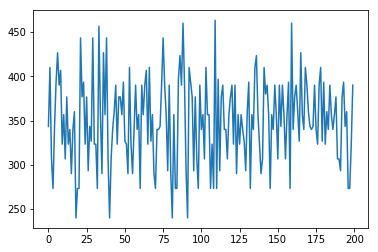

In [191]:
plt.plot(rewards)